In [1]:
# this notebook will show case how to use the helper function to train decision transformer agent with the dataset

# define the dataset path
dataset_path = "offline_stock_trade_data"

In [3]:
# first we need to calculate the mean and std of each feature in the dataset
from curatedataset import calc_meanstd_datasets
dataset_meanstd = calc_meanstd_datasets(dataset_path, ["positive", "negative", "neutral"])


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

opening files and creating datasets


Generating train split: 0 examples [00:00, ? examples/s]

Processing data as polars dataframe.
Forcing normalization
Dataset length:  200
offline_stock_trade_data/AVGO/momentum_stoch_rsi_AVGO_2018-02-05.json has 200 trajectories
Processing data as polars dataframe.
Forcing normalization
Dataset length:  200
offline_stock_trade_data/AVGO/random_AVGO_2018-02-05.json has 200 trajectories
Processing data as polars dataframe.
Forcing normalization
Dataset length:  200
offline_stock_trade_data/AVGO/sentiment_react_AVGO_2018-02-05.json has 200 trajectories
Processing data as polars dataframe.
Forcing normalization
Dataset length:  80
offline_stock_trade_data/AVGO/stable-baselines-ddpg_AVGO_2018-02-05.json has 80 trajectories
Processing data as polars dataframe.
Forcing normalization
Dataset length:  80
offline_stock_trade_data/AVGO/stable-baselines-a2c_AVGO_2018-02-05.json has 80 trajectories
Processing data as polars dataframe.
Forcing normalization
Dataset length:  80
offline_stock_trade_data/AVGO/stable-baselines-ppo_AVGO_2018-02-05.json has 80 t

100%|██████████| 3833/3833 [03:49<00:00, 16.72it/s]


Epoch 0: Loss: 0.15220126509666443


100%|██████████| 3833/3833 [03:40<00:00, 17.41it/s]


Epoch 39: Loss: 0.08215098083019257
Training time: 2:27:30.164641
Training complete


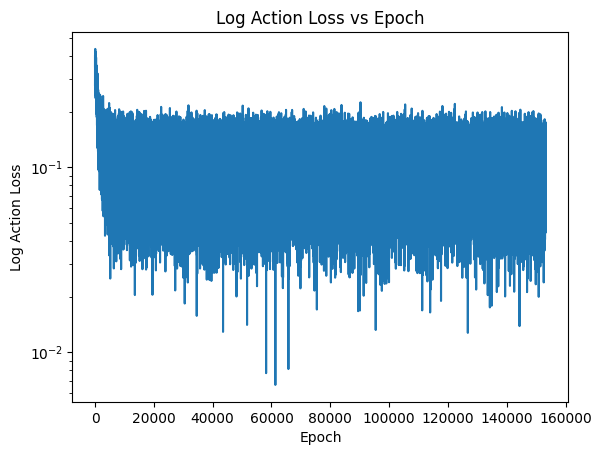

In [4]:
# then we can train the agent using the full_training_run helper function
from train_decision_transformer import full_training_run
import torch

# set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, trained_params = full_training_run(
    dataset_path, device = device, force_normalize=dataset_meanstd, n_epochs=40)

In [1]:
# save the trained model
from train_decision_transformer import save_model

model_name = 'nasdaq_dow_news_meanstd'
model_path = 'trained_nasdaq_dow_decision_transformer'
#save_model(trained_model, trained_params, model_name, model_path)

In [6]:
# we first need to see what are rewards distribution in the dataset

from curatedataset import eval_reward_datasets
mean_rewards = eval_reward_datasets(dataset_path)

shape: (1, 7)
┌──────────────┬─────────────┬─────────────┬────────────┬────────────┬───────────┬────────────┐
│ reward_min   ┆ reward_max  ┆ reward_10   ┆ reward_25  ┆ reward_50  ┆ reward_75 ┆ reward_90  │
│ ---          ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ---       ┆ ---        │
│ f64          ┆ f64         ┆ f64         ┆ f64        ┆ f64        ┆ f64       ┆ f64        │
╞══════════════╪═════════════╪═════════════╪════════════╪════════════╪═══════════╪════════════╡
│ -1360.068699 ┆ 1169.344348 ┆ -208.114125 ┆ -90.155418 ┆ -29.808543 ┆ 28.744407 ┆ 140.852024 │
└──────────────┴─────────────┴─────────────┴────────────┴────────────┴───────────┴────────────┘


In [2]:
# we then can use the reward as RTG for agent to trade
# rtg = mean_rewards['reward_75'][0]
rtg = 28.7

In [3]:
# we will then create the gym environment to test run the agent
# the gym environment will be normalized using the same mean_std as what is used to train the model

import json
import os
from TradingEnvClass import MeanStdObject

# get file end with params.json
json_files = [f for f in os.listdir(model_path) if f.endswith('params.json')]
parameter_path = os.path.join(model_path, json_files[0])
with open(parameter_path, 'r') as f:
    normalize = json.load(f)["normalize"]

mean_std_dict = {key: MeanStdObject(mean = value['mean'], std=value['std']) 
                 for key, value in normalize.items()}


In [5]:
from curatedataset import makegymenv, run_env
test_tic = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN', 'META', 'NVDA', 'INTC', 'AMD']

# TODO test different start date within the dataset 
start_date = '2020-06-01'
num_days = 365
interval = '1d'
indicators = ["Volume", "volume_cmf", "trend_macd", "momentum_rsi", "momentum_stoch_rsi", "trend_sma_fast"]
init_balance = 20000
test_env_list = []
#data = get_stock_data_yf_between_with_indicators(stock_name, '2019-01-01', '2020-02-01', interval, ['all'])

for stock_name in test_tic:
    env,obs_space, act_space, col, data = makegymenv(stock_name, start_date, num_days, interval, indicators=indicators, normalize=mean_std_dict, init_balance=init_balance)
    test_env_list.append(env)


Getting stock data of AAPL...


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '80.83004913330078' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Getting news sentiment of AAPL...
2021-05-10 2021-05-14
Error: Request timed out after 15 seconds
Getting stock data of AAPL completed.
init env with max step:  251
Getting stock data of MSFT...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of MSFT...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Getting stock data of MSFT completed.
init env with max step:  251
Getting stock data of GOOGL...



/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.11477142333985' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of GOOGL...
2021-04-14 2021-04-20
Error: Request timed out after 15 seconds
Getting stock data of GOOGL completed.
init env with max step:  251
Getting stock data of TSLA...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of TSLA...
2020-06-01 2020-06-02
Error: Request timed out after 15 seconds


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Getting stock data of TSLA completed.
init env with max step:  251
Getting stock data of AMZN...



/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '123.62501861572265' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of AMZN...
2020-08-27 2020-09-02
Error: Request timed out after 15 seconds
2020-09-09 2020-09-15
Error: Request timed out after 15 seconds
Getting stock data of AMZN completed.
init env with max step:  251
Getting stock data of META...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of META...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Getting stock data of META completed.
init env with max step:  251
Getting stock data of NVDA...



/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '88.25560241699219' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of NVDA...
2020-06-04 2020-06-10
Error: Request timed out after 15 seconds
Error with news sentiment function:  list index out of range
Error with news sentiment function:  list index out of range
Error with news sentiment function:  list index out of range
Error with news sentiment function:  list index out of range
Getting stock data of NVDA completed.
init env with max step:  251
Getting stock data of INTC...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of INTC...


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Getting stock data of INTC completed.
init env with max step:  251
Getting stock data of AMD...



/usr/local/lib/python3.10/dist-packages/ta/trend.py:988: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.551400909423826' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  self._psar.iloc[i] = self._psar.iloc[i - 1] + (
/usr/local/lib/python3.10/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


sorting indicators...
setting up sentiment analysis model...
Getting news sentiment of AMD...
Getting stock data of AMD completed.
init env with max step:  251


/code/src/curatedataset.py:38: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['momentum_stoch_rsi'].iloc[:10] = 0.5
/code/src/curatedataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [12]:
# then create an agent from model weight to interact with the environment
from get_agent import Agent
import torch
import fnmatch

# get model parameter's path under model path by checking for _params.json
f = os.listdir(model_path)
matching_files = fnmatch.filter(f, model_name+'*_params.json')
# get the file that store the model information
parameter_path = os.path.join(model_path, matching_files[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create agent (use the first env as sample env)
DecisionTransformer = Agent(test_env_list[0], 'transformer', rtg_target=rtg, rtg_scale=0.7, model_path=parameter_path, device=device)


Agent type:  transformer
Loading DecisionTransformer model


In [13]:
matching_files

['nasdaq_dow_news_meanstd_params.json']

In [7]:
# run and save the interaction data
from curatedataset import save_data

for env, stock_name in zip(test_env_list, test_tic):
    trade_data = run_env(DecisionTransformer, stock_name, env, 10, start_date, normalize_param = mean_std_dict)
    file_name = os.path.join(model_path, f'trained_transformer_{stock_name}_{start_date}_{num_days}_{interval}_test.json')
    save_data(trade_data, file_name)

Episode:  0 Timestep: 250  done
Episode:  1 Timestep: 250  done
Episode:  2 Timestep: 250  done
Episode:  3 Timestep: 250  done
Episode:  4 Timestep: 250  done
Episode:  5 Timestep: 250  done
Episode:  6 Timestep: 250  done
Episode:  7 Timestep: 250  done
Episode:  8 Timestep: 250  done
Episode:  9 Timestep: 250  done
Episode:  0 Timestep: 250  done
Episode:  1 Timestep: 250  done
Episode:  2 Timestep: 250  done
Episode:  3 Timestep: 250  done
Episode:  4 Timestep: 250  done
Episode:  5 Timestep: 250  done
Episode:  6 Timestep: 250  done
Episode:  7 Timestep: 250  done
Episode:  8 Timestep: 250  done
Episode:  9 Timestep: 250  done
Episode:  0 Timestep: 250  done
Episode:  1 Timestep: 250  done
Episode:  2 Timestep: 250  done
Episode:  3 Timestep: 250  done
Episode:  4 Timestep: 250  done
Episode:  5 Timestep: 250  done
Episode:  6 Timestep: 250  done
Episode:  7 Timestep: 250  done
Episode:  8 Timestep: 250  done
Episode:  9 Timestep: 250  done
Episode:  0 Timestep: 250  done
Episode:

In [26]:
# we then can use the evaluation helper to plot the stock price movement and trading action.
from curatedataset import evaluate_dataset

json_files = [f for f in os.listdir(model_path) if f.endswith('1d_test.json')]


['trained_transformer_META_2020-06-01_365_1d_test.json', 'trained_transformer_AAPL_2020-06-01_365_1d_test.json', 'trained_transformer_GOOGL_2020-06-01_365_1d_test.json', 'trained_transformer_MSFT_2020-06-01_365_1d_test.json', 'trained_transformer_INTC_2020-06-01_365_1d_test.json', 'trained_transformer_AMD_2020-06-01_365_1d_test.json', 'trained_transformer_TSLA_2020-06-01_365_1d_test.json', 'trained_transformer_NVDA_2020-06-01_365_1d_test.json', 'trained_transformer_AMZN_2020-06-01_365_1d_test.json']


trained_nasdaq_dow_decision_transformer/trained_transformer_NVDA_2020-06-01_365_1d_test.json
Mean sample sum reward:  -7250.177079464387
Std sample sum reward:  0.0
Mean net worth growth:  5926.98828125
Std net worth growth: +/- 0.0
Plotting episode:  4
check:  <class 'numpy.ndarray'>


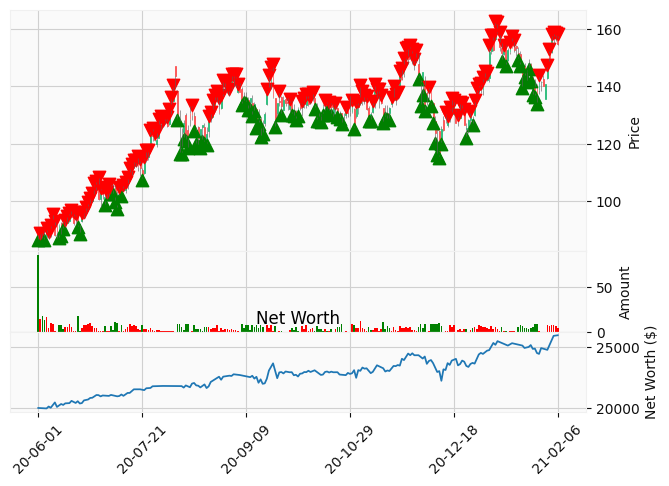

In [28]:
eval_data = os.path.join(model_path,json_files[7])
print(eval_data)
evaluate_dataset(eval_data)